<a href="https://colab.research.google.com/github/owlemily/AI-Kpop-Dance-Similarity-Analysis/blob/main/AI_Kpop_Dance_Similarity_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 전체적인 흐름
**1. 설치 및 라이브러리 import**

**2. 모델 로드**

**3. 두 영상 전처리**
- 영상 길이 일치
- fps 동일하게 유지

**4. Keypoints 추출**

**5. Keypoints 정규화**

**6. DTW를 통한 프레임 정렬**

**7. Weighted Cosine Similarity를 통한 유사도 측정**

**8. 시각화**
- Skeleton 시각화
- 유사도 시각화
- 합치기


# 설치

In [ ]:
!pip install -U -q git+https://github.com/huggingface/transformers
!pip install -q supervision
!pip install opencv-python-headless numpy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 4.9 MB/s eta 0:00:00


In [ ]:
!pip install fastdtw
!pip install dtaidistance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp311-cp311-linux_x86_64.whl size=542084 sha256=7e42ba720592634739ff99d367fb3476bf04c4e3622302f0412649e8859c4950
  Stored in directory: /root/.cache/pip/wheels/5c/8a/f6/fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built fastdtw
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 32.5 MB/s eta 0:00:00


In [ ]:
!apt-get update
!apt-get install ffmpeg

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,722 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,932 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,211 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Pac

# 라이브러리 import

In [ ]:
import cv2
import numpy as np
import PIL.Image
import torch
import tempfile
from tqdm import tqdm
import tqdm
import supervision as sv  # 시각화 도구
import subprocess

import requests
from PIL import Image
import PIL.Image
import tempfile
import json
from transformers import (
    AutoProcessor,
    RTDetrForObjectDetection,
    VitPoseForPoseEstimation,
)

from fastdtw import fastdtw
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

# 설정

In [ ]:
#디바이스를 설정합니다.
device = "cuda" if torch.cuda.is_available() else "cpu"

# 모델 로드

In [ ]:
# --- 모델 로드 ---
person_detector_name = "PekingU/rtdetr_r50vd_coco_o365"
person_image_processor = AutoProcessor.from_pretrained(person_detector_name)
person_model = RTDetrForObjectDetection.from_pretrained(person_detector_name).to(device)

pose_model_name = "usyd-community/vitpose-base-simple"
pose_image_processor = AutoProcessor.from_pretrained(pose_model_name)
pose_model = VitPoseForPoseEstimation.from_pretrained(pose_model_name).to(device)

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


preprocessor_config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/344M [00:00<?, ?B/s]

# 입력 비디오(2개) 경로를 입력하세요.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 비교할 비디오의 경로를 입력합니다.
video_1 = "/content/drive/MyDrive/NCT_127-Kick_It_highlight.mp4"
video_2 = "/content/drive/MyDrive/nj_illit/cut_ILLIT_MyWorld.mp4"

In [ ]:
# 전처리한 비디오를 저장할 경로를 입력합니다.
trimmed_video_1 = "/content/drive/MyDrive/trimmed/trimmed_video_nct_kick_it.mp4"
trimmed_video_2 = "/content/drive/MyDrive/trimmed/trimmed_video_illit.mp4"

# 두 영상의 FPS, 프레임수, 영상길이(초)를 일치시킵니다.

- 1) FPS 읽기
- 2) 예상 가능한 프레임 수 계산
- 3) **1차 자르기 시도**

  ffmpeg로 target FPS, target frames로 잘라낸다.
- 4) 실제 자른 프레임 수 확인

  예상보다 적게 잘렸는지 체크
- 5) **2차 재시도**

  실제 생성 가능한 최소 프레임수로 다시 자른다.

- 6) 검증 및 출력

  FPS, 프레임수, 길이 완벽히 동일한지 확인

In [ ]:
# --- 측정 함수 ---

#fps 측정
def get_fps(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"❌ 영상 열기 실패: {video_path}")
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()
    return fps

#영상 길이 측정
def get_duration(video_path):
    result = subprocess.run([
        "ffprobe", "-v", "error", "-select_streams", "v:0",
        "-show_entries", "format=duration", "-of",
        "default=nokey=1:noprint_wrappers=1", video_path
    ], capture_output=True, text=True)
    return float(result.stdout.strip())

#프레임수 측정
def get_frame_count(video_path):
    result = subprocess.run([
        "ffprobe", "-v", "error", "-select_streams", "v:0",
        "-count_frames", "-show_entries", "stream=nb_read_frames",
        "-of", "default=nokey=1:noprint_wrappers=1", video_path
    ], capture_output=True, text=True)
    return int(result.stdout.strip())

In [ ]:
# --- 자르기 함수 ---
def trim_video_uniform(input_path, output_path, num_frames, target_fps):
    cmd = [
        "ffmpeg", "-y", "-i", input_path,
        "-r", str(target_fps),
        "-frames:v", str(num_frames),
        "-an", "-c:v", "libx264",
        "-preset", "fast",
        output_path
    ]
    subprocess.run(cmd, check=True)

In [ ]:
# --- 전체 파이프라인 ---
def normalize_two_videos(video1_path, video2_path, out1_path, out2_path):
    # 측정
    fps1 = get_fps(video1_path)
    print("fps1:", fps1)
    fps2 = get_fps(video2_path)
    print("fps2:", fps2)
    frames1 = get_frame_count(video1_path)
    print("frames1:",frames1)
    frames2 = get_frame_count(video2_path)
    print("frames2:",frames2)
    duration1 = get_duration(video1_path)
    print("duration1:", duration1)
    duration2 = get_duration(video2_path)
    print("duration2:", duration2)

    # 타겟 fps, frame count 설정
    target_fps = min(fps1, fps2)
    print(f"Target FPS: {target_fps}")
    #est_frames1 = int(frames1 / (fps1 / target_fps))
    est_frames1 = frames1 if fps1 == target_fps else int(frames1 / (fps1 / target_fps))
    print("추정 frame1 개수:", est_frames1)
    est_frames2 = frames2 if fps2 == target_fps else int(frames2 / (fps2 / target_fps))
    print("추정 frame2 개수:", est_frames2)
    target_frames = min(est_frames1, est_frames2)
    print("Target frames:", target_frames)

    print(f"▶ 1차 시도: {target_frames} frames @ {target_fps} FPS")
    trim_video_uniform(video1_path, out1_path, target_frames, target_fps)
    trim_video_uniform(video2_path, out2_path, target_frames, target_fps)

    # 잘린 영상 실제 프레임 수 확인
    actual1 = get_frame_count(out1_path)
    actual2 = get_frame_count(out2_path)
    actual_frames = min(actual1, actual2)

    if actual_frames < target_frames:
        print(f"⚠️ 일부 영상에서 {target_frames}프레임 미만 생성됨 → {actual_frames}프레임으로 재시도")
        trim_video_uniform(video1_path, out1_path, actual_frames, target_fps)
        trim_video_uniform(video2_path, out2_path, actual_frames, target_fps)

    # 최종 검증
    for p in [out1_path, out2_path]:
        fps = get_fps(p)
        frames = get_frame_count(p)
        dur = get_duration(p)
        expected = frames / fps
        print(f"📁 {p} → FPS: {fps}, 프레임: {frames}, 길이: {dur:.5f}, 계산된 길이: {expected:.5f}")
        assert abs(dur - expected) < 0.01, "❌ 길이 불일치!"

In [ ]:
normalize_two_videos(video_1, video_2, trimmed_video_1, trimmed_video_2)

fps1: 23.98
fps2: 29.97
frames1: 624
frames2: 210
duration1: 26.022
duration2: 7.008
Target FPS: 23.98
추정 frame1 개수: 624
추정 frame2 개수: 168
Target frames: 168
▶ 1차 시도: 168 frames @ 23.98 FPS
📁 /content/drive/MyDrive/trimmed/trimmed_video_nct_kick_it.mp4 → FPS: 23.98, 프레임: 168, 길이: 7.00600, 계산된 길이: 7.00584
📁 /content/drive/MyDrive/trimmed/trimmed_video_illit.mp4 → FPS: 23.98, 프레임: 168, 길이: 7.00600, 계산된 길이: 7.00584


## MAX_NUM_FRAMES 상수 설정

In [ ]:
#MAX_NUM_FRAMES를 최대 상수로 설정하기 위해 아래를 실행합니다.
import math
max_frames = get_frame_count(trimmed_video_1)
print(max_frames)
MAX_NUM_FRAMES = math.ceil(max_frames / 100) * 100

print(MAX_NUM_FRAMES)

168
200


# Keypoints 추출하기

In [ ]:
@torch.inference_mode()
def process_image(image: PIL.Image.Image) -> tuple[PIL.Image.Image, list[dict]]:
    inputs = person_image_processor(images=image, return_tensors="pt").to(device)
    outputs = person_model(**inputs)
    results = person_image_processor.post_process_object_detection(
        outputs, target_sizes=torch.tensor([(image.height, image.width)]), threshold=0.3
    )
    result = results[0]  # take first image results

    #### Human label refers 0 index in COCO dataset ####
    person_mask = result["labels"] == 0 # 사람만 필터링
    person_boxes_xyxy = result["boxes"][person_mask]

    #------ 가운데 사람 한명만 선택합니다-------
    if len(person_boxes_xyxy) == 0:
        return image, []

    # 이미지 중심 x좌표
    image_center_x = image.width / 2

    # 모든 사람의 중심 x좌표 계산
    box_centers_x = (person_boxes_xyxy[:, 0] + person_boxes_xyxy[:, 2]) / 2

    # 중심과 가장 가까운 사람 인덱스
    center_idx = torch.argmin(torch.abs(box_centers_x - image_center_x))

    # 그 사람만 선택
    person_boxes_xyxy = person_boxes_xyxy[center_idx].unsqueeze(0)
    person_boxes_xyxy = person_boxes_xyxy.cpu().numpy()
    #----------------------------------------------------

    # Convert boxes from VOC (x1, y1, x2, y2) to COCO (x1, y1, w, h) format
    person_boxes = person_boxes_xyxy.copy()
    person_boxes[:, 2] = person_boxes[:, 2] - person_boxes[:, 0]
    person_boxes[:, 3] = person_boxes[:, 3] - person_boxes[:, 1]

    inputs = pose_image_processor(image, boxes=[person_boxes], return_tensors="pt").to(device)

    # for vitpose-plus-base checkpoint we should additionally provide dataset_index
    # to specify which MOE experts to use for inference
    if pose_model.config.backbone_config.num_experts > 1:
        dataset_index = torch.tensor([0] * len(inputs["pixel_values"]))
        dataset_index = dataset_index.to(inputs["pixel_values"].device)
        inputs["dataset_index"] = dataset_index

    outputs = pose_model(**inputs)

    pose_results = pose_image_processor.post_process_pose_estimation(outputs, boxes=[person_boxes])
    image_pose_result = pose_results[0]  # results for first image

    # make results more human-readable #결과 정제
    human_readable_results = []
    for i, person_pose in enumerate(image_pose_result):
        data = {
            "person_id": i,
            "bbox": person_pose["bbox"].numpy().tolist(),
            "keypoints": [],
        }
        for keypoint, label, score in zip(
            person_pose["keypoints"], person_pose["labels"], person_pose["scores"], strict=True
        ):
            keypoint_name = pose_model.config.id2label[label.item()]
            x, y = keypoint
            data["keypoints"].append({"name": keypoint_name, "x": x.item(), "y": y.item(), "score": score.item()})
        human_readable_results.append(data)

    # preprocess to torch tensor of shape (n_objects, n_keypoints, 2)
    xy = [pose_result["keypoints"] for pose_result in image_pose_result]
    xy = torch.stack(xy).cpu().numpy()

    scores = [pose_result["scores"] for pose_result in image_pose_result]
    scores = torch.stack(scores).cpu().numpy()

    keypoints = sv.KeyPoints(xy=xy, confidence=scores)
    detections = sv.Detections(xyxy=person_boxes_xyxy)

    # 색깔, 굵기 조정
    edge_annotator = sv.EdgeAnnotator(color=sv.Color.GREEN, thickness=2)
    vertex_annotator = sv.VertexAnnotator(color=sv.Color.RED, radius=2)
    bounding_box_annotator = sv.BoxAnnotator(color=sv.Color.WHITE, color_lookup=sv.ColorLookup.INDEX, thickness=2)

    annotated_frame = image.copy()

    # annotate bounding boxes
    annotated_frame = bounding_box_annotator.annotate(scene=image.copy(), detections=detections)

    # annotate edges and vertices
    annotated_frame = edge_annotator.annotate(scene=annotated_frame, key_points=keypoints)
    return vertex_annotator.annotate(scene=annotated_frame, key_points=keypoints), human_readable_results

In [ ]:
def process_video(
    video_path: str,
    keypoints_json_path: str,
    output_video_path: str,
    label_text: str,
    label_color: tuple
    #progress: gr.Progress = gr.Progress(track_tqdm=True),  # noqa: ARG001, B008
) -> str:

    #비디오 열기, 정보 가져오기(해상도-height, width, 프레임속도(fps), 총 프레임 수(num_frames))
    cap = cv2.VideoCapture(video_path)

    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print("height:", height)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    print("width:", width)
    fps = cap.get(cv2.CAP_PROP_FPS)
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    pose_keypoints_sequence = []  # 프레임별 Keypoints 저장

    #출력 비디오 파일 설정
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    with tempfile.NamedTemporaryFile(suffix=".mp4", delete=False) as out_file:
        #cv2.VideoWriter 객체로 비디오 파일 기록할 준비
        writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
        #프레임별로 처리합니다.
        for frame_idx in tqdm.auto.tqdm(range(min(MAX_NUM_FRAMES, num_frames))):
            ok, frame = cap.read()
            if not ok:
                print(f"❌ 프레임 읽기 실패 at frame {frame_idx}")
                break
            rgb_frame = frame[:, :, ::-1] #BGR이 OpenCV기본인데 RGB로 변환한다.
            annotated_frame, keypoints_data = process_image(PIL.Image.fromarray(rgb_frame))
            annotated_frame = np.asarray(annotated_frame)[:, :, ::-1].copy() #시각화된 프레임을 BGR로 변환하여 기록

            # ✅ 왼쪽 상단: 프레임 번호 표시
            # 🔻 video1 / video2 주석 추가 (프레임 번호 아래)
            cv2.putText(annotated_frame, label_text, (30, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, label_color, 3)
            cv2.putText(annotated_frame, f"Frame: {frame_idx}", (30, 105),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 100), 2) # 형광 하늘색


            # ✅ 오른쪽 상단: 첫 번째 keypoint 좌표 (예: 코 좌표 등)
            # ✅ 오른쪽 상단: 17개 keypoint 좌표를 모두 표시
            if keypoints_data and keypoints_data[0]["keypoints"]:
                for idx, kp in enumerate(keypoints_data[0]["keypoints"]):
                    x, y = round(kp["x"]), round(kp["y"])
                    coord_text = f"{idx}:({x},{y})"
                    y_offset = 20 + idx * 15  # 한 줄 간격 조정
                    cv2.putText(
                        annotated_frame,
                        coord_text,
                        (width - 140, y_offset),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.4,#글씨크기
                        (255, 255, 100),  # 형광 하늘색
                        1 #두께
                    )

            # 키포인트 시퀀스 기록
            if keypoints_data:
              pose_keypoints_sequence.append(keypoints_data[0]["keypoints"])
            writer.write(annotated_frame)
        writer.release()
    cap.release()
    # Keypoints 시퀀스 저장 (JSON)
    with open(keypoints_json_path, "w") as f:
        json.dump(pose_keypoints_sequence, f)

    print(f"✅ Keypoints Sequence 저장 완료: {keypoints_json_path}")
    return output_video_path #최종적으로 생성된 .mp4 파일경로 반환

# keypoints 추출 실행

In [ ]:
# 입력한 비디오의 키포인트 저장 경로를 입력합니다.
keypoints_1 = "/content/drive/MyDrive/keypoints/keypoints_nct_kick_it.json"
keypoints_2 = "/content/drive/MyDrive/keypoints/keypoints_illit_2.json"
#정규화한 키포인트 저장 경로를 입력합니다.
normalized_keypoints_1 = "/content/drive/MyDrive/keypoints/normalized_keypoints_nct_kick_it.json"
normalized_keypoints_2 = "/content/drive/MyDrive/keypoints/normalized_keypoints_illit_2.json"
# 결과 비디오를 저장 경로를 입력합니다.
output_video_path_1 = "/content/drive/MyDrive/keypoints_results/test/keypoints_nct_kick_it.mp4"
output_video_path_2 = "/content/drive/MyDrive/keypoints_results/test/keypoints_illit_2.mp4"

In [ ]:
process_video(trimmed_video_1, keypoints_1, output_video_path_1, "video1", (255, 0, 0)) #파랑으로 출력됨.

height: 360
width: 640


  0%|          | 0/168 [00:00<?, ?it/s]

✅ Keypoints Sequence 저장 완료: /content/drive/MyDrive/keypoints/keypoints_nct_kick_it.json


'/content/drive/MyDrive/keypoints_results/test/keypoints_nct_kick_it.mp4'

In [ ]:
process_video(trimmed_video_2, keypoints_2, output_video_path_2, "video2", (0,0,255))

height: 720
width: 1280


  0%|          | 0/210 [00:00<?, ?it/s]

✅ Keypoints Sequence 저장 완료: /content/drive/MyDrive/keypoints/keypoints_illit_2.json


'/content/drive/MyDrive/keypoints_results/test/keypoints_illit_2.mp4'

# keypoints 정규화
- 중심화와 L2 normalization을 적용합니다.

## 위에서 생성한 두 영상의 Keypoints sequence json 파일을 로드합니다.

In [ ]:
# 두 JSON 키포인트 로드
def load_keypoints(file_path):
    with open(file_path, "r") as f:
        return json.load(f)

In [ ]:
sequence1 = load_keypoints(keypoints_1)
sequence2 = load_keypoints(keypoints_2)

In [ ]:
keypoints_1

'/content/drive/MyDrive/keypoints/keypoints_njatten_2.json'

In [ ]:
print(sequence1)

[[{'name': 'Nose', 'x': 659.7867431640625, 'y': 351.64453125, 'score': 0.9781391024589539}, {'name': 'L_Eye', 'x': 667.3670654296875, 'y': 344.67633056640625, 'score': 1.0191144943237305}, {'name': 'R_Eye', 'x': 652.769287109375, 'y': 344.499267578125, 'score': 0.9587310552597046}, {'name': 'L_Ear', 'x': 680.005615234375, 'y': 351.24407958984375, 'score': 0.9327092170715332}, {'name': 'R_Ear', 'x': 643.0025634765625, 'y': 349.9482421875, 'score': 0.9619163870811462}, {'name': 'L_Shoulder', 'x': 695.8399658203125, 'y': 389.001220703125, 'score': 0.8738657236099243}, {'name': 'R_Shoulder', 'x': 623.9969482421875, 'y': 391.53302001953125, 'score': 0.9312203526496887}, {'name': 'L_Elbow', 'x': 726.9454345703125, 'y': 347.0618896484375, 'score': 0.971705973148346}, {'name': 'R_Elbow', 'x': 611.0899658203125, 'y': 353.59716796875, 'score': 0.6288690567016602}, {'name': 'L_Wrist', 'x': 767.6383056640625, 'y': 299.6676025390625, 'score': 0.988516628742218}, {'name': 'R_Wrist', 'x': 637.5966796

## 좌표 중심화와 L2 정규화 적용하기

In [ ]:
def center_and_normalize_keypoints(frame):
    keypoints = np.array([[joint["x"], joint["y"]] for joint in frame], dtype=np.float32)
    center = keypoints.mean(axis=0)
    centered = keypoints - center  # 중심화
    flattened = centered.flatten()

    norm = np.linalg.norm(flattened)
    if norm == 0:
        return flattened  # norm이 0이면 그대로 반환
    return flattened / norm  # L2 정규화

def extract_video_embedding_centered_normalized(sequence):
    frames = []
    for frame in sequence:
        frame_vector = center_and_normalize_keypoints(frame)
        frames.append(frame_vector)
    return np.array(frames, dtype=np.float32)


In [ ]:
seq1 = extract_video_embedding_centered_normalized(sequence1)
seq2 = extract_video_embedding_centered_normalized(sequence2)


In [ ]:
print(seq1)
print("=============")
print(seq2)

[[-0.01201559 -0.15036385  0.00205265 ...  0.42949995 -0.10560226
   0.42397216]
 [-0.01044932 -0.14809847  0.00271334 ...  0.42943838 -0.10534846
   0.42552283]
 [-0.00875022 -0.1689203   0.00387909 ...  0.42273682 -0.1054979
   0.41948444]
 ...
 [ 0.02191409 -0.23242491  0.0400879  ...  0.4109905  -0.1043667
   0.43191993]
 [ 0.02105735 -0.234375    0.03962552 ...  0.41369832 -0.10638998
   0.43328193]
 [ 0.01723345 -0.2288074   0.03703291 ...  0.42042685 -0.1097227
   0.44259998]]
[[-2.3271572e-02 -1.9925906e-01 -7.8160195e-03 ...  4.6551478e-01
  -1.5751763e-01  4.7042057e-01]
 [-1.9508000e-02 -1.9910493e-01 -3.2695164e-03 ...  4.6583366e-01
  -1.5978822e-01  4.7062802e-01]
 [-1.5025788e-02 -2.0029734e-01 -8.3740415e-05 ...  4.6647954e-01
  -1.6340235e-01  4.6883151e-01]
 ...
 [ 4.3918356e-02 -2.1093825e-01  5.6214869e-02 ...  4.4595763e-01
  -7.2613142e-02  4.8866674e-01]
 [ 4.0633880e-02 -2.1855375e-01  5.4510325e-02 ...  4.4556999e-01
  -7.7855647e-02  4.8421046e-01]
 [ 3.206576

In [ ]:
print(seq1.shape)

(210, 34)


In [ ]:
seq1[0].shape

(34,)

## 정규화한 keypoints 좌표 json파일로 저장

In [ ]:
# 저장 함수 정의
def save_numpy_to_json(arr, filepath):
    with open(filepath, 'w') as f:
        json.dump(arr.tolist(), f)

In [ ]:
# 저장 실행
save_numpy_to_json(seq1, normalized_keypoints_1)
save_numpy_to_json(seq2, normalized_keypoints_2)

# DTW를 통한 프레임 정렬
**(커버댄스의 경우 DTW는 선택사항입니다. 실행해도 되고 안해도 됩니다.)**

In [ ]:
# DTW 정렬 수행
distance, path = fastdtw(seq1, seq2, dist=cosine)
print(path)

[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 32), (33, 33), (34, 34), (35, 35), (36, 36), (37, 37), (37, 38), (38, 39), (39, 40), (40, 41), (41, 42), (42, 43), (43, 44), (44, 45), (45, 46), (46, 47), (46, 48), (46, 49), (46, 50), (46, 51), (46, 52), (47, 53), (47, 54), (47, 55), (47, 56), (47, 57), (47, 58), (47, 59), (47, 60), (47, 61), (47, 62), (47, 63), (47, 64), (47, 65), (47, 66), (47, 67), (47, 68), (47, 69), (47, 70), (47, 71), (47, 72), (47, 73), (47, 74), (47, 75), (47, 76), (47, 77), (47, 78), (47, 79), (47, 80), (47, 81), (47, 82), (47, 83), (47, 84), (47, 85), (47, 86), (47, 87), (47, 88), (47, 89), (47, 90), (47, 91), (47, 92), (47, 93), (47, 94), (47, 95), (48, 96), (49, 97), (50, 98), (51, 99), (52, 100), (53, 101

#위의 DTW를 실행하지 않았다면 이 셀을 반드시 실행하세요!
***DTW를 실행했다면 실행하지 마십시오!***
프레임 별 인덱스(path)를 설정하는 셀입니다.

In [ ]:
path = []
for i in range(max_frames):
    path += [(i, i)]

In [ ]:
print(path)

[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 32), (33, 33), (34, 34), (35, 35), (36, 36), (37, 37), (38, 38), (39, 39), (40, 40), (41, 41), (42, 42), (43, 43), (44, 44), (45, 45), (46, 46), (47, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (84, 84), (85, 85), (86, 86), (87, 87), (88, 88), (89, 89), (90, 90), (91, 91), (92, 92), (93, 93), (94, 94), (95, 95), (96, 96), (97, 97), (98, 98), (99, 99), (100, 100), (101, 1

# COCO 17 keypoints의 가중치 설정
유사도에 더 큰 영향을 미치는 부위에 가중치를 적용하여 유사도 계산에 중요하게 반영하도록 합니다.

In [ ]:
# COCO 17 keypoints 순서 기준
'''keypoint_weights = np.array([
    0.05, # nose
    0.02, 0.02, # eyes
    0.02, 0.02, # ears
    0.15, 0.15, # shoulders
    0.1, 0.1, # elbows
    0.1, 0.1, # wrists
    0.15, 0.15, # hips
    0.1, 0.1, # knees
    0.07, 0.07, # ankles
])'''
'''
가중치의 선정 기준
- 커버댄스와 표절감지 둘의 차이를 고려해서 가중치를 설정할수도있음
- 뉴진스와 뉴진스

'''
keypoint_weights = np.array([
    0.01,  # nose
    0.005, 0.005,  # eyes
    0.005, 0.005,  # ears
    0.2, 0.2,  # shoulders
    0.15, 0.15,  # elbows
    0.15, 0.15,  # wrists
    0.15, 0.15,  # hips
    0.12, 0.12,  # knees
    0.08, 0.08   # ankles
])

#keypoint_weights = np.ones(17)

# 2D 좌표 (x, y)에 각각 적용할 경우
keypoint_weights = np.repeat(keypoint_weights, 2) #(34, )

In [ ]:
keypoint_weights.shape

(34,)

# 정렬된 프레임 쌍 별 weighted cosine similarity 측정

In [ ]:
# 인덱스별 코사인 유사도 계산
similarities = []
for i, j in path:
    vec_1 = seq1[i].flatten() #(34,)
    #print(vec_1.shape)
    vec_2 = seq2[j].flatten() #(34,)
    #print(vec_2.shape)
    assert vec_1.shape == vec_2.shape == keypoint_weights.shape
    #weight 적용
    w_1 = vec_1 * keypoint_weights
    #print(w_1.shape)
    w_2 = vec_2 * keypoint_weights
    #print(w_2.shape)
    cos_sim = 1 - cosine(w_1, w_2)  # 1 - cosine distance
    similarities.append(cos_sim)

print(similarities)

[np.float64(0.8871460434625191), np.float64(0.8829459204769922), np.float64(0.830125537987864), np.float64(0.8405980743575134), np.float64(0.849106628891633), np.float64(0.8407170485769911), np.float64(0.8514113726121173), np.float64(0.8464457823060008), np.float64(0.8790303125491279), np.float64(0.8376742803537003), np.float64(0.7444026774044937), np.float64(0.7424882899039851), np.float64(0.8087040717087125), np.float64(0.8095736998130263), np.float64(0.816678996780689), np.float64(0.8090674236634043), np.float64(0.8048631029843818), np.float64(0.7906878853626996), np.float64(0.7800401701408562), np.float64(0.7434962338196505), np.float64(0.760714491084072), np.float64(0.783243998076093), np.float64(0.7950497213916075), np.float64(0.8161839392143588), np.float64(0.8142383262419925), np.float64(0.8366190636118005), np.float64(0.8425654664213995), np.float64(0.843509853150793), np.float64(0.8347208965205031), np.float64(0.7787695871837308), np.float64(0.7713946079357914), np.float64(0.

In [ ]:
len(similarities)

265

In [ ]:
# 평균 유사도 출력
average_similarity = np.mean(similarities)
print(f"평균 유사도: {average_similarity * 100:.2f}%")

평균 유사도: 77.31%


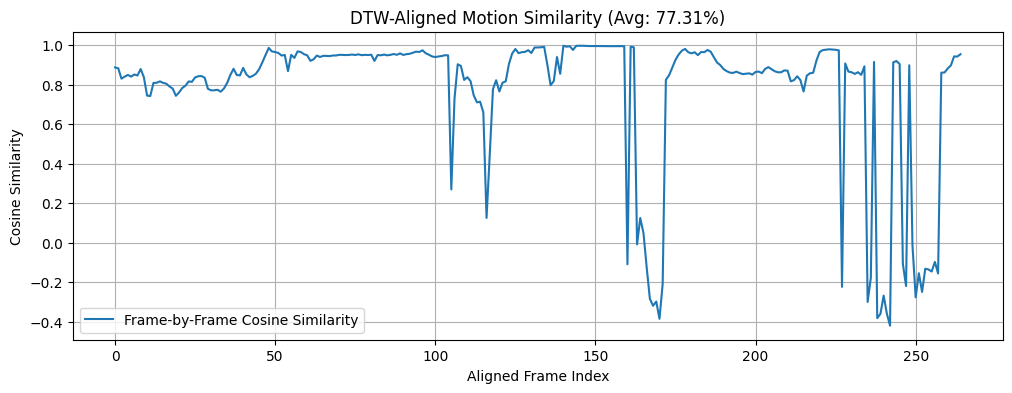

In [ ]:
# 유사도 그래프 시각화
plt.figure(figsize=(12, 4))
plt.plot(similarities, label="Frame-by-Frame Cosine Similarity")
plt.xlabel("Aligned Frame Index")
plt.ylabel("Cosine Similarity")
plt.title(f"DTW-Aligned Motion Similarity (Avg: {average_similarity * 100:.2f}%)")
plt.legend()
plt.grid(True)
plt.show()

# 두 keypoints 영상 합치기
- keypoint 표시된 두 영상을 dtw로 정렬한 프레임 path대로 영상을 합칩니다.

In [ ]:
import cv2
import numpy as np

def show_dtw_aligned_clip(video_path1, video_path2, path, output_path, max_pairs=len(path)):
    cap1 = cv2.VideoCapture(video_path1)
    cap2 = cv2.VideoCapture(video_path2)
    '''
    width1 = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH))
    height1 = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))


    width2 = int(cap2.get(cv2.CAP_PROP_FRAME_WIDTH))
    height2 = int(cap2.get(cv2.CAP_PROP_FRAME_HEIGHT))

    width = max(width1, width2)
    height = max(height1, height2)
    '''
    #===========================
    # 고정 width 설정
    fixed_width = 512

    # 원본 height에서 비율 계산 (비율은 동일하다고 가정)
    orig_width = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH))
    orig_height = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))
    aspect_ratio = orig_height / orig_width
    fixed_height = int(fixed_width * aspect_ratio)
    #===========================
    fps = cap1.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter(output_path, fourcc, fps, (fixed_width, fixed_height*2))

    for count, (i, j) in enumerate(path[:max_pairs]):
        cap1.set(cv2.CAP_PROP_POS_FRAMES, i)
        cap2.set(cv2.CAP_PROP_POS_FRAMES, j)

        ret1, frame1 = cap1.read()
        ret2, frame2 = cap2.read()

        if not (ret1 and ret2):
            print(f"⚠️ 프레임 불러오기 실패: ({i}, {j})")
            break

        # 해상도 맞추기
        frame1 = cv2.resize(frame1, (fixed_width, fixed_height))
        frame2 = cv2.resize(frame2, (fixed_width, fixed_height))

        combined = np.vstack((frame1, frame2))
        writer.write(combined)

    cap1.release()
    cap2.release()
    writer.release()
    return output_path


In [ ]:
# 비슷한 두 영상을 합쳐서 저장할 경로를 입력하세요
aligned_path = "/content/drive/MyDrive/aligned_keypoints/aligned_clip_njillit_fixed_wh_2.mp4"

In [ ]:
aligned_clip_path = show_dtw_aligned_clip(
    video_path1=output_video_path_1,
    video_path2=output_video_path_2,
    path=path,  # DTW에서 얻은 (i, j) 쌍 리스트
    output_path=aligned_path
)


# Skeleton 시각화

In [ ]:
#정규화된 keypoints json파일을 불러오기위해.
def flat_to_keypoints(flat_kp):
    return [{"x": flat_kp[i], "y": flat_kp[i + 1]} for i in range(0, len(flat_kp), 2)]

In [ ]:
'''
img: 흰 배경 캔버스
keypoints: 17개의 COCO keypoints(x,y를 포함한 딕셔너리 리스트)
anchor_idx: 기준이 되는 keypoint 인덱스(기본값은 11=left hip)
'''
def draw_skeleton_with_face_fixed(img, keypoints, color=(255, 255, 255),
                                   canvas_center=None, target_size=300):
    # (1) 정규화된 [-1, 1] 좌표 → pixel 좌표 변환
    keypoints_arr = np.array([[kp['x'], kp['y']] for kp in keypoints])

    if np.any(np.isnan(keypoints_arr)) or len(keypoints_arr) == 0:
        return img

    # === 추가: 정규화된 keypoints를 canvas pixel 좌표로 변환 ===
    # 중심이 (0,0), 좌표 범위가 [-1, 1]이라면:
    # → (x, y) * (target_size / 2) + canvas_center
    if canvas_center is None:
        canvas_center = np.array([img.shape[1] // 2, img.shape[0] // 2])

    keypoints_arr = (keypoints_arr * (target_size / 2)) + canvas_center

    # 유효 keypoints만 추출
    valid_points = keypoints_arr[(keypoints_arr > 0).all(axis=1)]
    if len(valid_points) == 0:
        return img

    # === bbox 중심 기준 이동 (이동 후 다시 정렬) ===
    bbox_min = valid_points.min(axis=0)
    bbox_max = valid_points.max(axis=0)
    bbox_center = (bbox_min + bbox_max) / 2

    shift = canvas_center - bbox_center
    moved_keypoints = keypoints_arr + shift

    # === 크기 정규화 ===
    bbox_w = bbox_max[0] - bbox_min[0]
    bbox_h = bbox_max[1] - bbox_min[1]
    bbox_size = max(bbox_w, bbox_h)

    if bbox_size > 0:
        scale_factor = target_size / bbox_size
        moved_keypoints = ((moved_keypoints - canvas_center) * scale_factor + canvas_center)

    moved_keypoints = moved_keypoints.astype(int)

    # === 스켈레톤 그리기 ===
    skeleton = [
        [5,6], [5,7], [7,9],
        [6,8], [8,10],
        [5,11], [6,12], [11,12],
        [11,13], [13,15],
        [12,14], [14,16]
    ]

    for p1, p2 in skeleton:
        if (moved_keypoints[p1] > 0).all() and (moved_keypoints[p2] > 0).all():
            cv2.line(img, tuple(map(int, moved_keypoints[p1])), tuple(map(int, moved_keypoints[p2])), color, 3)

    if (moved_keypoints[0] > 0).all():
        cv2.circle(img, tuple(map(int, moved_keypoints[0])), 15, color, 3)

    return img



def create_overlay_skeleton_video(video_path1, video_path2, keypoints_json_path1, keypoints_json_path2, color1, color2, output_path, dtw_path = None):
    cap1 = cv2.VideoCapture(video_path1)
    cap2 = cv2.VideoCapture(video_path2)

    with open(keypoints_json_path1, "r") as f:
      raw_seq1 = json.load(f)
    keypoints_seq1 = [flat_to_keypoints(frame) if isinstance(frame[0], float) else frame for frame in raw_seq1]

    with open(keypoints_json_path2, "r") as f:
      raw_seq2 = json.load(f)
    keypoints_seq2 = [flat_to_keypoints(frame) if isinstance(frame[0], float) else frame for frame in raw_seq2]
    '''
    w = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))

    canvas_center = np.array([w // 2, h // 2])
    '''
    fps = cap1.get(cv2.CAP_PROP_FPS)
    #=========================
    # 합성했을 때 비율을 위해 고치기
    h = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))
    full_width = 1280
    w = int(full_width * 2.5 / 10)  # 2.5 비율
    canvas_center = np.array([w // 2, h // 2])
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
    #=========================
    target_size = 300 # 스켈레톤 크기 고정 기준 (px)

    idx = 0
    if dtw_path is None:
        # DTW가 없으면 기본 프레임 동기화
       dtw_path = list(zip(range(min(len(keypoints_seq1), len(keypoints_seq2))),
                           range(min(len(keypoints_seq1), len(keypoints_seq2)))))

    for i1, i2 in dtw_path:
        ret1 = cap1.set(cv2.CAP_PROP_POS_FRAMES, i1)
        ret2 = cap2.set(cv2.CAP_PROP_POS_FRAMES, i2)
        ret1, frame1 = cap1.read()
        ret2, frame2 = cap2.read()
        if not ret1 or not ret2:
            break

        white_bg1 = np.ones((h, w, 3), dtype=np.uint8) * 255
        white_bg2 = np.ones((h, w, 3), dtype=np.uint8) * 255


        keypoints1 = keypoints_seq1[i1]
        keypoints2 = keypoints_seq2[i2]

        skeleton1 = draw_skeleton_with_face_fixed(white_bg1, keypoints1, color1, canvas_center, target_size=300)
        skeleton2 = draw_skeleton_with_face_fixed(white_bg2, keypoints2, color2, canvas_center, target_size=300)

        overlay = cv2.addWeighted(skeleton1, 0.5, skeleton2, 0.5, 0)
        # === 🔽 오른쪽 아래에 DTW path 표시 추가 ===
        text = f"DTW match: ({i1}, {i2})"
        cv2.putText(overlay, text, (30, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2, cv2.LINE_AA)

        # 🔴🔵 video1 / video2 선 + 주석 추가
        line_y = 60
        line_length = 100
        line_thickness = 3
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.6
        thickness = 2

        # 빨간 선과 주석
        start_point1 = (30, line_y)
        end_point1 = (30 + line_length, line_y)
        cv2.line(overlay, start_point1, end_point1, color1, line_thickness)
        cv2.putText(overlay, "video1", (end_point1[0] + 10, line_y + 5),
                    font, font_scale, color1, thickness, cv2.LINE_AA)

        # 파란 선과 주석
        start_point2 = (30, line_y + 40)
        end_point2 = (30 + line_length, line_y + 40)
        cv2.line(overlay, start_point2, end_point2, color2, line_thickness)
        cv2.putText(overlay, "video2", (end_point2[0] + 10, line_y + 5 + 40),
                    font, font_scale, color2, thickness, cv2.LINE_AA)
        out.write(overlay)


    cap1.release()
    cap2.release()
    out.release()

In [ ]:
# 스캘레톤 동영상을 저장할 경로를 입력하세요
skeleton_output_path = "/content/drive/MyDrive/skeletons/test/overlay_output_njillit_fix_wh_2.mp4"

In [ ]:
create_overlay_skeleton_video(
    # 키포인트 표시된 영상 저장 경로(위에서부터 순차적으로 실행했다면 건드리지 않아도 됩니다.)
    video_path1= output_video_path_1,
    video_path2= output_video_path_2,
    # 키포인트 json 파일 저장 경로(위에서부터 순차적으로 실행했다면 건드리지 않아도 됩니다.)
    keypoints_json_path1= keypoints_1,
    keypoints_json_path2= keypoints_2,
    color1=(255, 0, 0),  # 빨간 스켈레톤
    color2=(0, 0, 255),  # 파란 스켈레톤
    output_path= skeleton_output_path,
    dtw_path = path
)

# 유사도 시각화
기존의 정규화한 keypoints json 파일을 가져와서 유사도 계산에 사용합니다.

In [ ]:
#정규화한 keypoints json 파일과 그냥 keypoints json파일 둘다 처리할 수 있도록 합니다.
def load_keypoints_from_json(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)

    if isinstance(data[0][0], dict):  # {"x": ..., "y": ...}
        return np.array([[[kp["x"], kp["y"]] for kp in frame] for frame in data])
    elif isinstance(data[0][0], (int, float)):  # [x1, y1, ..., x17, y17]
        return np.array([np.array(frame).reshape(17, 2) for frame in data])
    else:
        raise ValueError("Unknown keypoint format")


In [ ]:
# JSON 경로
#keypoint json파일 경로 입력하기
ref_json_path = normalized_keypoints_1
cmp_json_path = normalized_keypoints_2

#video 경로 입력하기
ref_video_path = output_video_path_1
cmp_video_path = output_video_path_2

# json 파일 불러오기
ref_keypoints = load_keypoints_from_json(ref_json_path)  # shape: (N1, 17, 2)
cmp_keypoints = load_keypoints_from_json(cmp_json_path)  # shape: (N2, 17, 2)

In [ ]:
print(ref_json_path)
print(cmp_json_path)
print(ref_video_path)
print(cmp_video_path)

/content/drive/MyDrive/keypoints/normalized_keypoints_njatten_2.json
/content/drive/MyDrive/keypoints/normalized_keypoints_illit_2.json
/content/drive/MyDrive/keypoints_results/test/keypoints_njatten_2.mp4
/content/drive/MyDrive/keypoints_results/test/keypoints_illit_2.mp4


In [ ]:
# --- 유사도 계산 함수 ---
# 각 포인트 별로 유사도 계산 하는 부분
def compute_frame_keypoint_similarities(ref_kps, cmp_kps, keypoint_weights=None):
    similarities = []

    for k in range(17):
        ref_vec = ref_kps[k]
        cmp_vec = cmp_kps[k]

        if keypoint_weights is not None:
            ref_vec = ref_vec * keypoint_weights[k]
            cmp_vec = cmp_vec * keypoint_weights[k]

        if np.linalg.norm(ref_vec) == 0 or np.linalg.norm(cmp_vec) == 0:
          sim = 0.0
        else:
          sim = 1 - cosine(ref_vec, cmp_vec)
          sim = max(sim, 0.0)  # ⛔ 음수 방지


        similarities.append(sim * 100)  # 0~100%
    return similarities, np.mean(similarities)


# --- 고정 포즈 정의 ---
# keypoint 스캘래톤 바탕 COCO 17 포인트 순서대로
fixed_pose_coords = {
    0: (250, 80),   1: (230, 70),  2: (270, 70),  3: (215, 80),  4: (285, 80),
    5: (200, 130), 6: (300, 130), 7: (180, 180), 8: (320, 180),
    9: (160, 230), 10: (340, 230),
    11: (210, 230), 12: (290, 230),
    13: (200, 300), 14: (300, 300),
    15: (190, 370), 16: (310, 370)
}

skeleton_edges = [
    (5, 6), (5, 7), (7, 9), (6, 8), (8, 10),
    (5, 11), (6, 12), (11, 12),
    (11, 13), (13, 15), (12, 14), (14, 16)
]
#----------------------------

#상체, 하체 유사도 결과
upper_body_idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
lower_body_idx = [11, 12, 13, 14, 15, 16]


# --- 고정 스켈레톤 프레임 그리기 ---
def draw_fixed_skeleton_frame(similarities, fixed_pose_coords, skeleton_edges, canvas_size=(450, 500)):
    h, w = canvas_size
    canvas = np.ones((h, w, 3), dtype=np.uint8) * 255

    # 중심 정렬
    target_center = np.array([w // 2, h // 2])
    pelvis_center = np.array([
        (fixed_pose_coords[11][0] + fixed_pose_coords[12][0]) // 2,
        (fixed_pose_coords[11][1] + fixed_pose_coords[12][1]) // 2
    ])
    shift = target_center - pelvis_center
    moved_coords = {k: (v[0] + shift[0], v[1] + shift[1]) for k, v in fixed_pose_coords.items()}

    # 스켈레톤 그리기
    for (i, j) in skeleton_edges:
        cv2.line(canvas, moved_coords[i], moved_coords[j], (0, 200, 255), 2)

    for idx, coord in moved_coords.items():
        sim_score = similarities[idx]
        cv2.circle(canvas, coord, 6, (0, 0, 0), -1)
        cv2.putText(canvas, f"{sim_score*100:.1f}%", (coord[0]-20, coord[1]-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, (50, 50, 255), 1)

    return canvas


# --- 텍스트 상단 출력 ---
def add_overall_similarity_text(img, overall_score, top_score, bottom_score, frame_pair = None):
    cv2.putText(img, f"Overall: {overall_score:.2f}%", (30, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    cv2.putText(img, f"Top: {top_score:.2f}%", (30, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 100, 255), 2)
    cv2.putText(img, f"Bottom: {bottom_score:.2f}%", (30, 90),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 100, 255), 2)
    if frame_pair is not None:
        i, j = frame_pair
        cv2.putText(img, f"DTW: ({i} , {j})", (30, 120),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (100, 100, 100), 2)
    return img


# --- 최종 영상 생성 ---
def create_similarity_video(ref_seq, cmp_seq, path, output_path, keypoint_weights=None, size=(720, 720), fps=None):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, size)

    for i, j in path:
        ref_kps = ref_seq[i]
        cmp_kps = cmp_seq[j]

        similarities, _ = compute_frame_keypoint_similarities(ref_kps, cmp_kps, keypoint_weights)
        similarities_np = np.array(similarities) / 100.0

        overall = np.mean(similarities_np)
        top = np.mean([similarities_np[i] for i in upper_body_idx])
        bottom = np.mean([similarities_np[i] for i in lower_body_idx])

        canvas = draw_fixed_skeleton_frame(similarities_np, fixed_pose_coords, skeleton_edges, canvas_size=(size[1], size[0]))
        canvas = add_overall_similarity_text(canvas, overall * 100, top * 100, bottom * 100, frame_pair= (i, j))

        out.write(canvas)

    out.release()

In [ ]:
# 유사도 시각화 영상을 저장할 경로를 입력하세요.
similarity_output_path = "/content/drive/MyDrive/similarity/similarity_visualization_njillit_fix_wh.mp4"

In [ ]:
#fps 지정
fps = get_fps(output_video_path_1)
print(fps)
#유사도 영상 생성하기
create_similarity_video(
    ref_seq=ref_keypoints,
    cmp_seq=cmp_keypoints,
    path=path,
    output_path=similarity_output_path,
    keypoint_weights=None,
    size=(350, 720),
    fps = fps
)

29.97


### 확인

In [ ]:
frame_keypoints_1 = get_frame_count(output_video_path_1)
frame_keypoints_2 = get_frame_count(output_video_path_2)
frame_alligned = get_frame_count(aligned_path)
frame_skeleton = get_frame_count(skeleton_output_path)
frame_similarity = get_frame_count(similarity_output_path)
fps_keypoints_1 = get_fps(output_video_path_1)
fps_keypoints_2 = get_fps(output_video_path_2)
fps_alligned = get_fps(aligned_path)
fps_skeleton = get_fps(skeleton_output_path)
fps_similarity = get_fps(similarity_output_path)
duration_keypoints_1 = get_duration(output_video_path_1)
duration_keypoints_2 = get_duration(output_video_path_2)
duration_alligned = get_duration(aligned_path)
duration_skeleton = get_duration(skeleton_output_path)
duration_similarity = get_duration(similarity_output_path)
print("<프레임 개수>")
print("keypoint1 영상:",frame_keypoints_1)
print("keypoint2 영상:", frame_keypoints_2)
print("dtw 적용 후 keypoints 영상:", frame_alligned)
print("스캘레톤 영상:",frame_skeleton)
print("유사도 영상:",frame_similarity)
print("============")
print("<fps 확인>")
print("keypoint1 영상:",fps_keypoints_1)
print("keypoint2 영상:", fps_keypoints_2)
print("dtw 적용 후 keypoints 영상:", fps_alligned)
print("스캘레톤 영상:",fps_skeleton)
print("유사도 영상:",fps_similarity)
print("============")
print("<영상 길이 확인>")
print("keypoint1 영상:",duration_keypoints_1)
print("keypoint2 영상:", duration_keypoints_2)
print("dtw 적용 후 keypoints 영상:", duration_alligned)
print("스캘레톤 영상:",duration_skeleton)
print("유사도 영상:",duration_similarity)

<프레임 개수>
keypoint1 영상: 210
keypoint2 영상: 210
dtw 적용 후 keypoints 영상: 265
스캘레톤 영상: 265
유사도 영상: 265
<fps 확인>
keypoint1 영상: 29.97
keypoint2 영상: 29.97
dtw 적용 후 keypoints 영상: 29.97
스캘레톤 영상: 29.97
유사도 영상: 29.97
<영상 길이 확인>
keypoint1 영상: 7.008
keypoint2 영상: 7.008
dtw 적용 후 keypoints 영상: 8.843
스캘레톤 영상: 8.843
유사도 영상: 8.843


# Skeleton 영상과 유사도 영상 가로로 합치기

In [ ]:
# 두 영상을 합칠 경로를 입력하세요.
skeleton_similarity_combined_path = '/content/drive/MyDrive/similarity_skeletons/combined_output_nj_illit_fix_wh.mp4'

In [ ]:
# 두 영상 경로
similarity_path = similarity_output_path
skeleton_path = skeleton_output_path

# 두 영상 열기
cap1 = cv2.VideoCapture(similarity_path)
cap2 = cv2.VideoCapture(skeleton_path)

# 출력 설정
fps = cap1.get(cv2.CAP_PROP_FPS)
width = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))

# 두 번째 영상 크기를 첫 번째 영상에 맞게 조정
output_size = (width * 2, height)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(skeleton_similarity_combined_path, fourcc, fps, output_size)

while True:
    ret1, frame1 = cap1.read()
    ret2, frame2 = cap2.read()

    if not ret1 or not ret2:
        break

    # 크기 맞추기
    frame2 = cv2.resize(frame2, (width, height))

    # 좌우 병합
    combined_frame = cv2.hconcat([frame1, frame2])

    out.write(combined_frame)

cap1.release()
cap2.release()
out.release()
#cv2.destroyAllWindows()

In [ ]:
print("<skeleton과 similarity를 합쳤을 때>")
frame_ss = get_frame_count(skeleton_similarity_combined_path)
print("frame: ", frame_ss)
fps_ss = get_fps(skeleton_similarity_combined_path)
print("fps: ", fps_ss)
duration_ss = get_duration(skeleton_similarity_combined_path)
print("duration: ", duration_ss)

<skeleton과 similarity를 합쳤을 때>
frame:  265
fps:  29.97
duration:  8.843


# 최종 영상: keypoint 영상과 유사도 영상 가로로 합치기
- keypoints 영상, 유사도 표시영상, skeleton영상을 합칩니다.

In [ ]:
# 최종적으로 합칠 두 영상의 경로를 입력하세요.(위부터 차례로 실행했다면 고칠 필요 없습니다.)
alligned_keypoints_video_path = aligned_path
skeleton_similarity_video_path = skeleton_similarity_combined_path

# 최종 영상을 저장할 경로를 입력하세요.
final_video_path = '/content/drive/MyDrive/final_combined/final_test_fix_wh.mp4'

In [ ]:
# 두 영상 열기
cap1 = cv2.VideoCapture(alligned_keypoints_video_path)
cap2 = cv2.VideoCapture(skeleton_similarity_video_path)

# 출력 설정
fps = int(cap1.get(cv2.CAP_PROP_FPS))
width = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))

# 두 번째 영상 크기를 첫 번째 영상에 맞게 조정
output_size = (width * 2, height)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(final_video_path, fourcc, fps, output_size)

while True:
    ret1, frame1 = cap1.read()
    ret2, frame2 = cap2.read()

    if not ret1 or not ret2:
        break

    # 크기 맞추기
    frame2 = cv2.resize(frame2, (width, height))

    # 좌우 병합
    combined_frame = cv2.hconcat([frame1, frame2])

    out.write(combined_frame)

cap1.release()
cap2.release()
out.release()
#cv2.destroyAllWindows()